# Performance evaluation using classical optimizers

The variational Quantum Eigensolver (VQE) is an algorithm that have been proposed for various problems such as Quantum Chemistry, Machine learning and others. VQE is used to find a wave function ansatz of a molecule such as Hydrogen or Lithium Hydride and estimate the expectation value of it's Hamiltonian while a classical optimizer is used to adjust the quantum circuit parameters in order to find the molecule's ground state energy. In order to find ground state energy, we primarily follow three steps- 

1. Define the quantum circuit to prepare the ansatz 

2. Calculate the expectation value of the observable quantity of the Hamiltonian 

3. Optimize circuit parameters to compute molecular properties.

In [1]:
!pip install qiskit -q
!pip install pylatexenc -q
!pip install qiskit_nature -q
!pip install qutip -q
!pip install pyscf -q
!pip install tqdm -q

In [2]:
from DA_VQE import *
import warnings
warnings.simplefilter("ignore")

In [3]:
LiH_op, LiH_problem, LiH_converter = load_Molecule("LiH")
print(f'Number of qubits: {LiH_op.num_qubits}')
ref_value = energy_solver(LiH_op)
print(f'Bonding energy value: {ref_value:.5f}')
ref_value = total_energy_solver(LiH_problem, LiH_converter)
print(f'Total energy: {ref_value:.5f}')

The atomic distance is  1.545 Å


/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


Number of qubits: 4
Bonding energy value: -8.89100
Total energy: -7.86347


In [4]:
seed = 175
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,shots=8192) 

In [5]:
from numbers import Number
import numpy

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector


from qiskit.extensions.unitary import UnitaryGate

# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeffs, label=None):
        if isinstance(time, Number) and time != numpy.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        self.h_coeff1 = h_coeffs[0]
        self.h_coeff2 = h_coeffs[1]
        self.h_coeff3 = h_coeffs[2]
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeffs[0], h_coeffs[1], h_coeffs[2]], label=label)
        # note that params[0] is time, params[1] is num_qubits, params[2] is connectivity
        # params[3] is h_coeff1, params[4] is h_coeff2, params[5] is h_coeff3

    def __array__(self, dtype=None):
        """Return matrix for the unitary."""
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        """Calculate a subcircuit that implements this unitary."""
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections = len(self.connectivity)
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)
        xx_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_x interactions
        yy_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_y interactions

        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3]) * np.array(qt.tensor(ops_to_tensor)) #+= 
        # repeat for xx and yy interaction hamiltonian. Note that we will change the params[] index    
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmax()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmax()
            xx_hamiltonian += float(self.params[4]) * np.array(qt.tensor(ops_to_tensor)) 
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmay()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmay()
            yy_hamiltonian += float(self.params[5]) * np.array(qt.tensor(ops_to_tensor)) 
            # now assemble the full hamiltonian
        hamiltonian = zz_hamiltonian + xx_hamiltonian + yy_hamiltonian    
        return hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeffs, qubits, label=None):
    """Apply hamiltonian evolution to qubits."""
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits=len(qubits), connectivity=connectivity, h_coeffs = h_coeffs, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian

In [6]:
def digital_analogue_ansatz(Operator, entanglement = "entire"):
    # First we need to define variational parameters (at least one) phi[...]
    n_qubits = Operator.num_qubits
    phi = ParameterVector("phi", 4 * n_qubits)
    
    if entanglement == "entire":
        t = Parameter("t")
        psi = ParameterVector("psi",3)
        connectivity_arr = []
        qubits_arr = [0]
        for i in range(n_qubits - 1):
            connectivity_arr.append([i, i+1])
            qubits_arr.append(i+1)
    
    if entanglement == "staggered":
        psi = ParameterVector("psi",3*(n_qubits - 1))
        
    # Create a quantum circuit that is used for the ansatz
    ansatz = QuantumCircuit(n_qubits)
    #circuit
    for i in range(n_qubits):
        ansatz.rx(phi[2*i], i)
        ansatz.rz(phi[2*i+1], i)
    if entanglement == "entire":
        ansatz.custom_hamiltonian(connectivity=connectivity_arr, h_coeffs=psi, time=t , qubits=qubits_arr,label='analog block')
    if entanglement == "staggered":
        for i in range(n_qubits - 1):
            ansatz.custom_hamiltonian(connectivity=[[0, 1]], h_coeffs= psi[3*i:3*i+3], time=1, qubits=[i,i+1], label='$U_{}(t)$'.format(i))
    ##
    for i in range(n_qubits):
        ansatz.rz(phi[2*n_qubits+2*i], i)
        ansatz.rx(phi[2*n_qubits+2*i+1], i)
        
    if entanglement == "entire":
        ansatz.bind_parameters({t: 0.3})
        ansatz.bind_parameters({psi[0]: 0.3})
        ansatz.bind_parameters({psi[1]: 0.3})
        ansatz.bind_parameters({psi[2]: 0.3})
    if entanglement == "staggered":
        for i in range(n_qubits -1):
            ansatz.bind_parameters({psi[i]: 0.3})
    return ansatz

In [7]:
ansatz = digital_analogue_ansatz(LiH_op)

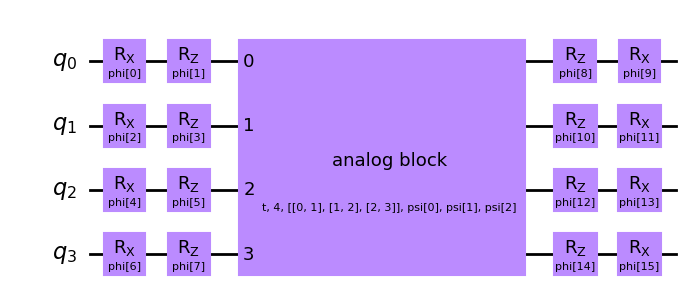

In [8]:
ansatz.draw(output="mpl")

In [9]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, GradientDescent, ADAM, SPSA
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance, algorithm_globals

In [10]:
learning_rate = 0.01
optimizers = [
    COBYLA(maxiter=1000), 
    L_BFGS_B(maxiter=1000), 
    SLSQP(maxiter=1000), 
    GradientDescent(maxiter=1000, learning_rate=learning_rate),
    ADAM(maxiter=1000, lr=learning_rate), 
    SPSA(maxiter=1000)
]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
    result = vqe.compute_minimum_eigenvalue(operator=LiH_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');



Optimization complete             


In [11]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 2000,
    'eigenstate': array([-0.01963051+0.00220766j, -0.14586683+0.10823296j,
        0.02783111-0.03748672j,  0.34618922-0.01531875j,
       -0.12596615+0.10416202j,  0.04554767+0.09184819j,
        0.10322313-0.01013181j,  0.17928094-0.51640947j,
        0.01307952-0.00661745j,  0.22482068-0.25841067j,
       -0.01782698-0.10036804j, -0.10247102-0.28920644j,
       -0.14440445+0.12363315j, -0.19241996+0.24860594j,
        0.19274375-0.16480785j, -0.18264546-0.20698806j]),
    'eigenvalue': (-7.364655388171789+0j),
    'optimal_parameters': {   Parameter(t): 1.6097630776729086,
                              ParameterVectorElement(phi[12]): -3.274976226212265,
                              ParameterVectorElement(phi[13]): -5.18474141169933,
                              ParameterVectorElement(phi[14]): -6.30049081572365,
                              ParameterVectorElement(phi[15]): 7.68653631857692,
                  

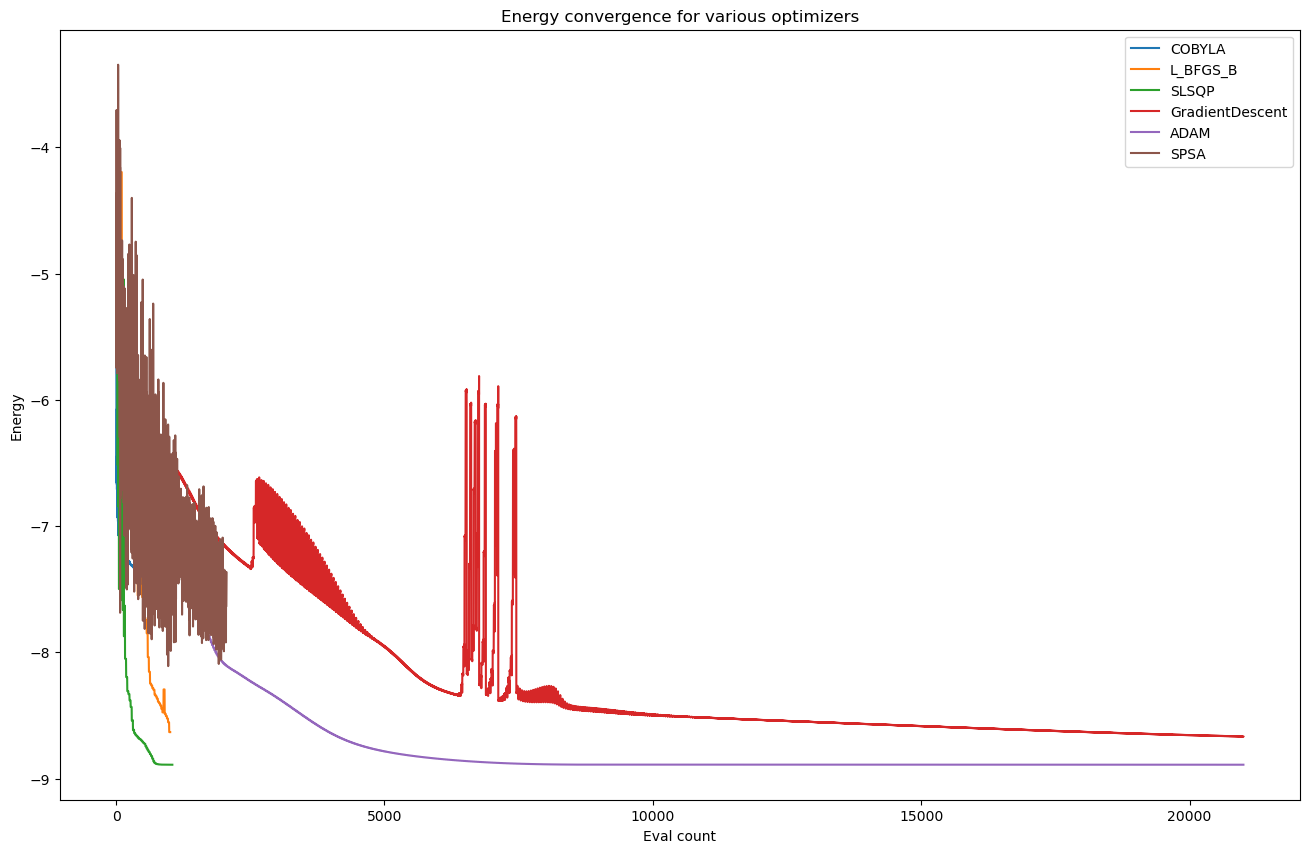

In [16]:
pylab.rcParams['figure.figsize'] = (16, 10)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');
pylab.savefig("plot.png")
pylab.show()